## 샤프 지수(Sharpe Ratio) 이용한 포트폴리오 최적화
- 위험 대비 성과 측정 지표
- Sharpe = (포트폴리오 평균 수익률 - 무위험 이자율) / 포트폴리오 수익률 표준편차

### 개별 종목 머지(merge)

In [167]:
import pandas as pd
from pykrx import stock

In [168]:
start_date = '20200101'
end_date = '20211231'
symbols = ['035420','196170','042700','005930'] # Naver, 알트로젠, 한미반도체, 삼성전자

In [169]:
# concate DataFrames 
df_stock = pd.DataFrame()
for symbol in symbols:
    df_stock[symbol] = stock.get_market_ohlcv_by_date(start_date, end_date, symbol)['종가'] # 네이버

df_stock


,035420,196170,042700,005930
날짜,,,,
2020-01-02,182500,19413,3980,55200
2020-01-03,181500,18746,3985,55500
2020-01-06,180500,17494,3920,55500
2020-01-07,187000,17995,3925,55800
2020-01-08,183000,16883,3925,56800
...,...,...,...,...
2021-12-24,384000,58389,18050,80500
2021-12-27,380500,59807,18300,80200
2021-12-28,384500,62809,18425,80300


In [170]:
#데일리 수익률
daily_return = df_stock.pct_change(periods = 1) # pct_change 는 shift 와 mean 을 한번에
daily_return

,035420,196170,042700,005930
날짜,,,,
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,-0.005479,-0.034358,0.001256,0.005435
2020-01-06,-0.005510,-0.066788,-0.016311,0.000000
2020-01-07,0.036011,0.028638,0.001276,0.005405
2020-01-08,-0.021390,-0.061795,0.000000,0.017921
...,...,...,...,...
2021-12-24,0.015873,-0.014082,0.000000,0.007509
2021-12-27,-0.009115,0.024285,0.013850,-0.003727
2021-12-28,0.010512,0.050195,0.006831,0.001247


In [171]:
# 리스크 점수 구하기
annual_return = daily_return.mean() * 252
annual_return

035420    0.437258
196170    0.883705
042700    0.946450
005930    0.217409
dtype: float64

In [172]:
# 공분산
daily_cov = daily_return.cov()
daily_cov

,035420,196170,042700,005930
035420,0.000526,0.000409,0.000260,0.000159
196170,0.000409,0.002319,0.000473,0.000185
042700,0.000260,0.000473,0.001220,0.000283
005930,0.000159,0.000185,0.000283,0.000315


In [173]:
annual_cov = daily_cov * 252
annual_cov

,035420,196170,042700,005930
035420,0.132514,0.102990,0.065583,0.039966
196170,0.102990,0.584310,0.119117,0.046511
042700,0.065583,0.119117,0.307320,0.071432
005930,0.039966,0.046511,0.071432,0.079495


### 비율 생성과 정규화

In [174]:
import numpy as np

weights = np.random.random(len(symbols)) #비율 랜덤생성 #gpt 한테 물어보기
# weights, type(weights), weights.shape
weights = weights / np.sum(weights) # 정규화
weights, type(weights), np.sum(weights)

(array([0.30447001, 0.31791936, 0.36268988, 0.01492075]),
 numpy.ndarray,
 1.0000000000000002)

In [175]:
returnofrate = np.dot(weights, annual_return)
# returns, type(returns)
risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) # sqrt = 루트
risk, type(risk)

(0.41863573929789877, numpy.float64)

In [176]:
np.dot(annual_cov, weights)

array([0.09747155, 0.26101728, 0.17036545, 0.0540488 ])

In [177]:
np.dot(weights.T, np.dot(annual_cov, weights))

0.17525588221749824

In [178]:
# 여러 포트폴리오 비율 적용

portfolio_returnofrate = list()
portfolio_risks = list()
portfolio_weights = list()
sharpe_ration = list()

for number in range(200):
    weights = np.random.random(len(symbols)) #비율 랜덤생성 #gpt 한테 물어보기
    weights = weights / np.sum(weights) # 정규화
    returnofrate = np.dot(weights, annual_return)
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) # sqrt = 루트
    
    portfolio_weights.append(weights)
    portfolio_returnofrate.append(returnofrate)
    portfolio_risks.append(risk)
    sharpe_ration.append(returnofrate / risk)

In [179]:
# Convert DataFrame : Return of rate, Risk, weights
portfolio = {
            "ReturnOfRate" : portfolio_returnofrate
             , "Risk" : portfolio_risks
             , "Sharpe" : sharpe_ration
             }

for idx, symbol in enumerate(symbols):
    portfolio[symbol] = [weight[idx] for weight in portfolio_weights]
    pass

df_portfolio = pd.DataFrame(portfolio)
df_portfolio.head(3)

,ReturnOfRate,Risk,Sharpe,035420,196170,042700,005930
0,0.472223,0.287009,1.645324,0.376955,0.065412,0.176063,0.381570
1,0.632279,0.350790,1.802445,0.146970,0.194096,0.347351,0.311582
2,0.546865,0.333585,1.639356,0.212128,0.254957,0.154920,0.377995


In [180]:
# df_portfolio['Sharpe'].max()
max_index = df_portfolio['Sharpe'].idxmax()
df_portfolio.iloc[max_index]

ReturnOfRate    0.761292
Risk            0.401317
Sharpe          1.896982
035420          0.276524
196170          0.204240
042700          0.475975
005930          0.043262
Name: 56, dtype: float64

In [181]:
# 위험도 감소
# df_portfolio['Risk'].min()
idx_min_risk = df_portfolio.iloc[df_portfolio['Risk'].idxmin()]


<!-- ### Charts 작성 -->

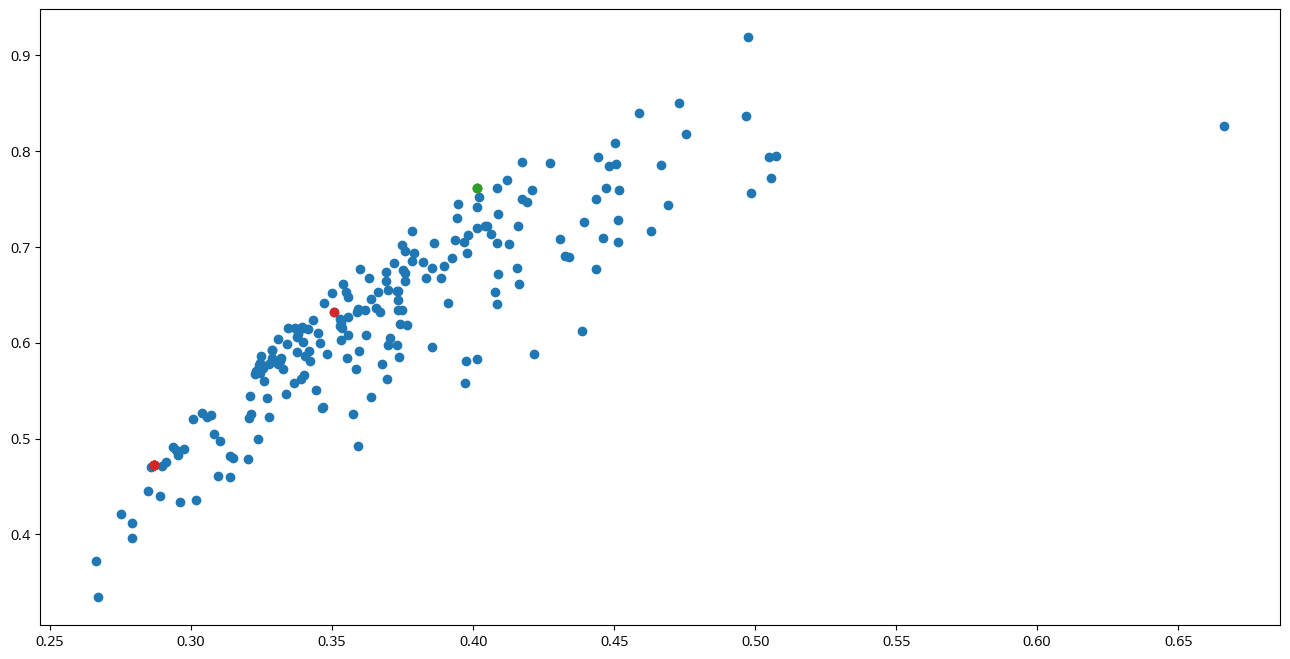

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.scatter(x=df_portfolio['Risk'], y=df_portfolio['ReturnOfRate'])
plt.scatter(x=df_portfolio.iloc[max_index]['Risk'], y=df_portfolio.iloc[max_index]['ReturnOfRate'])
plt.scatter(x=df_portfolio.iloc[idx_min_risk]['Risk'], y=df_portfolio.iloc[idx_min_risk]['ReturnOfRate'])

plt.show()